In [1]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import os
import re
import cv2
import tensorflow as tf
import glob
# import tensorflow.keras as keras
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
import segmentation_models as sm

Segmentation Models: using `keras` framework.


## Train data

In [2]:
train_filenames = []
for subdir, dirs, files in os.walk('./data/train'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            
            train_filenames.append(filepath)
            
train_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
train_filenames = np.array(train_filenames)

all_img_patches = []

for img_file in train_filenames:  
    large_image = tiff.imread(img_file)
    patches_img = patchify(large_image, (128, 128, 3), step=128)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j, 0, :, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

train_images = np.array(all_img_patches)

In [3]:
train_mask_filenames = []
for subdir, dirs, files in os.walk('./data/train_mask'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            train_mask_filenames.append(filepath)
            
train_mask_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
train_mask_filenames = np.array(train_mask_filenames)          

all_mask_patches = []

for img_file in train_mask_filenames:  
     
    large_mask = tiff.imread(img_file)  
    patches_mask = patchify(large_mask, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

train_masks = np.array(all_mask_patches)

In [4]:
print(train_images.shape)
print(train_masks.shape)
print("Pixel values in the mask are: ", np.unique(train_masks))

(3480, 128, 128, 3)
(3480, 128, 128)
Pixel values in the mask are:  [0 1 2 3 4]


In [5]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
print(train_masks.shape)
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

(3480, 128, 128)


C:\Users\ayush\anaconda3\envs\img_seg\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([0, 1, 2, 3, 4], dtype=int64)

## Test data

In [6]:
test_filenames = []
for subdir, dirs, files in os.walk('./data/test'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            test_filenames.append(filepath)
            
test_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
test_filenames = np.array(test_filenames)

all_img_patches = []

for img_file in test_filenames:  
    large_image = tiff.imread(img_file)
    #large_image = cv2.imread(img_path, 0)    
    patches_img = patchify(large_image, (128, 128, 3), step=128)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j, 0, :, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

test_images = np.array(all_img_patches)

In [7]:
test_mask_filenames = []
for subdir, dirs, files in os.walk('./data/test_mask'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            test_mask_filenames.append(filepath)
            
test_mask_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
test_mask_filenames = np.array(test_mask_filenames)          

all_mask_patches = []

for img_file in test_mask_filenames:  
    large_mask = tiff.imread(img_file)   
    #large_image = cv2.imread(img_path, 0)    
    patches_mask = patchify(large_mask, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

test_masks = np.array(all_mask_patches)

In [8]:
print(test_images.shape)
print(test_masks.shape)
print("Pixel values in the mask are: ", np.unique(test_masks))

(2280, 128, 128, 3)
(2280, 128, 128)
Pixel values in the mask are:  [0 1 2 3 4]


In [9]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
print(train_masks.shape)
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

(3480, 128, 128)


array([0, 1, 2, 3, 4], dtype=int64)

In [10]:
from tensorflow.keras.utils import normalize

print(train_images.shape)
#train_images = np.expand_dims(train_images, axis=3)
print(train_images.shape)

train_images = normalize(train_images, axis=1)
print(train_images.shape)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

print(train_masks_input.shape)

(3480, 128, 128, 3)
(3480, 128, 128, 3)
(3480, 128, 128, 3)
(3480, 128, 128, 1)


In [11]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4]


In [12]:
print(X_train.shape)

(2505, 128, 128, 3)


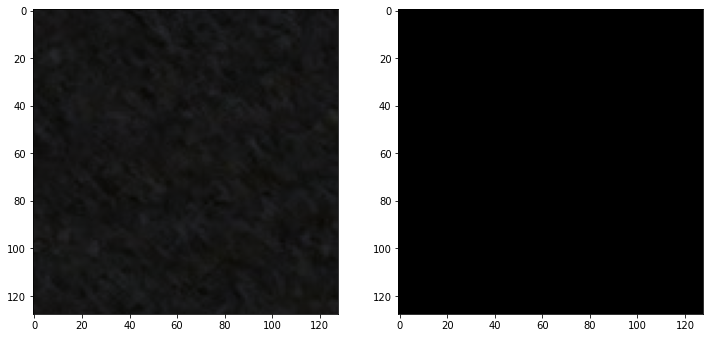

In [13]:
#Sanity check, view few mages
import random
import numpy as np

image_number = random.randint(0, len(X_train))

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')

plt.show()

In [14]:
from tensorflow.keras.utils import to_categorical

n_classes = 5
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print(y_train_cat.shape)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_test_cat.shape)

(2505, 128, 128, 5)
(348, 128, 128, 5)


## Model

In [15]:
def unet_resnet_backbone(BACKBONE, n_classes=5):
    BACKBONE1 = BACKBONE

    # define model
    model = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation='softmax')

    return model

In [16]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [20]:
import tensorflow.keras as keras

In [21]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
X_train = preprocess_input1(X_train)
X_test = preprocess_input1(X_test)


model = unet_resnet_backbone(BACKBONE=BACKBONE, n_classes=5)

model.compile(keras.optimizers.Adam(0.0001), total_loss, metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_test_50_epochs_8_batch_size_resnet_unet.log', separator=',', append=False)

history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #sample_weight=class_weights,
                    callbacks=[csv_logger])

model.save('test_50_epochs_8_batch_size_resnet_unet.hdf5')

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

## Plots

In [ ]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('test_50_epochs_8_batch_size_resnet_unet_loss.jpg')
plt.show()


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('test_50_epochs_8_batch_size_resnet_unet_accuracy.jpg')
plt.show()

In [ ]:
#IOU
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)


##################################################

#Using built in keras function
from keras.metrics import MeanIoU

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[0,4] + values[1,0] + values[2,0] + values[3,0] + values[4,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] +values[1, 4] + values[0,1]+ values[2,1]+ values[3,1] + values[4,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] +values[2, 4] + values[0,2]+ values[1,2]+ values[3,2] + values[4,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] +values[3, 4] + values[0,3]+ values[1,3]+ values[2,3] + values[4,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4, 3] + values[0,4]+ values[1,4]+ values[2,4] + values[3,4])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)

In [ ]:
import pandas as pd

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

data = {
    'Classes':  ['class1', 'class2', 'class3', 'class4', 'class5'],
    'IoU': [class1_IoU,  class2_IoU,  class3_IoU,  class4_IoU,  class5_IoU],
        }

df = pd.DataFrame(data)

print(df)

In [ ]:
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

print('Image number', test_img_number)


test_img_input=test_img[:,:,:][None, :,:]
print(test_img_input.shape)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')

plt.show()

## Large Image Check

In [ ]:
from patchify import patchify, unpatchify

img_file = 'data/train/img1.tiff'
large_image = tiff.imread(img_file)
print('Original image size: ', large_image.shape)

patches = patchify(large_image, (128, 128, 3), step=128) 
print(patches.shape)

In [ ]:
predicted_patches = []

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        #print(i,j)
        single_patch = patches[i,j, 0, :, :, :]
        single_patch_norm = normalize(single_patch, axis=0)
        single_patch_norm_wtf = single_patch_norm[:,:,:][None, :,:]
        single_patch_prediction = model.predict(single_patch_norm_wtf)
        
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0,:,:]
        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

In [ ]:
from PIL import Image

result = Image.new('P', (1920, 1024))

k = 0
for i in range(8):
    for j in range(15):
        PIL_image = Image.fromarray((predicted_patches[k] * 100).astype('uint8'), 'P')
        result.paste(PIL_image, (j*128, i*128))
        k += 1
        
plt.imsave('check_for_large_image.png',result, cmap='gray')
plt.imshow(result, cmap='gray')

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')

plt.subplot(222)
plt.title('Prediction of large Image 1')
plt.imshow(result, cmap='gray')

plt.subplot(223)
plt.title('Prediction of large Image 2')
plt.imshow(result, cmap='jet')

plt.show()